# Setup

In [76]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import f_oneway  # ANOVA test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
results_df = pd.read_csv('../../data/topic_model_results.csv',  lineterminator='\n', encoding='utf8')
#results_df = pd.read_csv('./topic_model_results.csv',  lineterminator='\n', encoding='utf8')

In [5]:
results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation\r,hateful Score,hateful HR,toxic Score,toxic HR\r,Topic Number,Topic\r
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political\r
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships\r
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships\r
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime\r
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown\r


In [6]:
# Remove \r from column names
results_df.columns = results_df.columns.str.strip()

# Strip \r and other whitespace characters from a specific column (e.g., 'column_name')
results_df['Topic'] = results_df['Topic'].str.strip()

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful Score,hateful HR,toxic Score,toxic HR,Topic Number,Topic
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown


In [7]:
# rename new columns
results_df.rename(columns={
    'hateful Score': 'hateful_score',
    'hateful HR': 'hateful_prediction',
    'toxic Score': 'toxic_score',
    'toxic HR': 'toxic_prediction',
    'Topic Number': 'topic_number',
    'Topic': 'topic'
}, inplace=True)

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown


In [8]:
# convert data to appropriate datatypes
results_df['text'] = results_df['text'].astype(str)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], format='%d/%m/%Y %H:%M')
results_df['username'] = results_df['username'].astype(str)
results_df['link'] = results_df['link'].astype(str)
results_df['link_id'] = results_df['link_id'].astype(str)
results_df['parent_id'] = results_df['parent_id'].astype(str)
results_df['id'] = results_df['id'].astype(str)
results_df['subreddit_id'] = results_df['subreddit_id'].astype(str)
results_df['moderation'] = results_df['moderation'].tolist()
results_df['hateful_score'] = results_df['hateful_score'].astype('float32')
results_df['hateful_prediction'] = results_df['hateful_prediction'].astype('int16')
results_df['toxic_score'] = results_df['toxic_score'].astype('float32')
results_df['toxic_prediction'] = results_df['toxic_prediction'].astype('int16')
results_df['topic_number'] = results_df['topic_number'].astype('category')
results_df['topic'] = results_df['topic'].astype('category')

In [9]:
# extract date from datetime stamp
results_df['timestamp'] = results_df['timestamp'].dt.date
# results_df['timestamp'].head()

# Analysis Scope and Topic Selection

We analyse the toxicity and hatefulness of reddit comments on a topical level, generally (not taking time into account).

We also test our following hypothesis:
- Consistent Toxicity & Hatefulness: Topics that reflect Singapore’s societal structure (e.g., *Race & Religion*, *Relationships*, *Education*, *Housing*, *Work*, and *Transport*.) may exhibit ongoing, consistent levels of toxicity and hatefulness. They tend to be more frequently discussed.
- Big Spike Events: Certain high-profile events (e.g., *Covid-19*, *General Elections (political)*, *Crime incidents*) trigger temporary but intense increases in toxic or hateful comments. They tend to be one-off but intense discussions.

- **Hypothesis**: Comments regarding topics of big spike events would have higher hatefulness and toxicity as compared to consistent, everyday topics.

#### Approach to Topic Selection
Topics for the toxicity and hatefulness analysis were selected based on:
  1. **Topic Modelling Results**: Our topic modelling used seeded topics. Each seeded topic was chosen based on keywords relevant to Singapore’s sociopolitical context. Initial exploratory data analysis identified several prevalent discussion themes that we included as seeded topics as well.
  2. **Sensitivity of Topics**: Research and observations indicate that topics related to race, religion, and politics in Singapore often evoke strong opinions and are therefore likely to exhibit consistent toxicity and hatefulness.
  3. **Relevance to Research Questions**: The analysis aims to shed light on how toxicity and hatefulness are distributed across sensitive and everyday topics, helping inform social media moderation and public policy.

This scope provides a balanced view of toxic and hateful patterns in both sensitive and routine contexts within Singaporean discussions.

In [46]:
# Topics selected for seeding in topic modelling
unique_topics = results_df['topic'].unique()

topic_counts = results_df['topic'].value_counts()

unique_topic_data = [(topic, results_df.loc[results_df['topic'] == topic, 'topic_number'].iloc[0], topic_counts[topic])
                     for topic in unique_topics]

topics_df = pd.DataFrame(unique_topic_data, columns=['Topic', 'Topic Number', 'Number of Comments']).sort_values(by='Topic Number')
topics_df.reset_index(drop=True, inplace=True)
topics_df

,Topic,Topic Number,Number of Comments
0,Political,0,34519
1,Covid-19,1,37649
2,Race & Religion,2,51109
3,Transport,3,31380
4,Relationships,4,34657
5,Crime,5,46975
6,Housing,6,27467
7,Education,7,33762
8,Work,8,19009
9,Unknown,9,79771


# 1. Comparative Analysis of Toxicity and Hatefulness Scores by Topic

## 1.1 Descriptive Statistics & Distribution of Scores

### Descriptive statistics

In [54]:
topic_stats = results_df.groupby('topic')[['toxic_score', 'hateful_score']].agg(['mean', 'median', 'std']).reset_index()
topic_stats

/var/folders/3v/wqs0tv2d5lx83t5kmv4kx_zr0000gn/T/ipykernel_33841/2294997498.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_stats = results_df.groupby('topic')[['toxic_score', 'hateful_score']].agg(['mean', 'median', 'std']).reset_index()


topic toxic_score                     hateful_score            \
                          mean    median       std          mean    median   
0         Covid-19   -0.472685 -0.535648  0.578988     -0.968609 -0.993017   
1            Crime   -0.480970 -0.545571  0.577028     -0.970119 -0.995348   
2        Education   -0.477676 -0.541311  0.577727     -0.967761 -0.993437   
3          Housing   -0.486003 -0.550627  0.577059     -0.972205 -0.995324   
4        Political   -0.486639 -0.552154  0.578058     -0.971467 -0.995549   
5  Race & Religion   -0.481562 -0.546193  0.580083     -0.969118 -0.994141   
6    Relationships   -0.480626 -0.543351  0.581723     -0.968313 -0.993761   
7        Transport   -0.478342 -0.543079  0.579202     -0.969834 -0.994252   
8          Unknown   -0.445050 -0.512912  0.591850     -0.960016 -0.987681   
9             Work   -0.481812 -0.546468  0.582189     -0.968115 -0.992473   

             
        std  
0  0.192525  
1  0.195153  
2  0.195666  
3  0.191050  
4  0.190738  
5  0.193493  
6  0.195536  
7  0.193569  
8  0.198539  
9  0.193723

### Boxplots

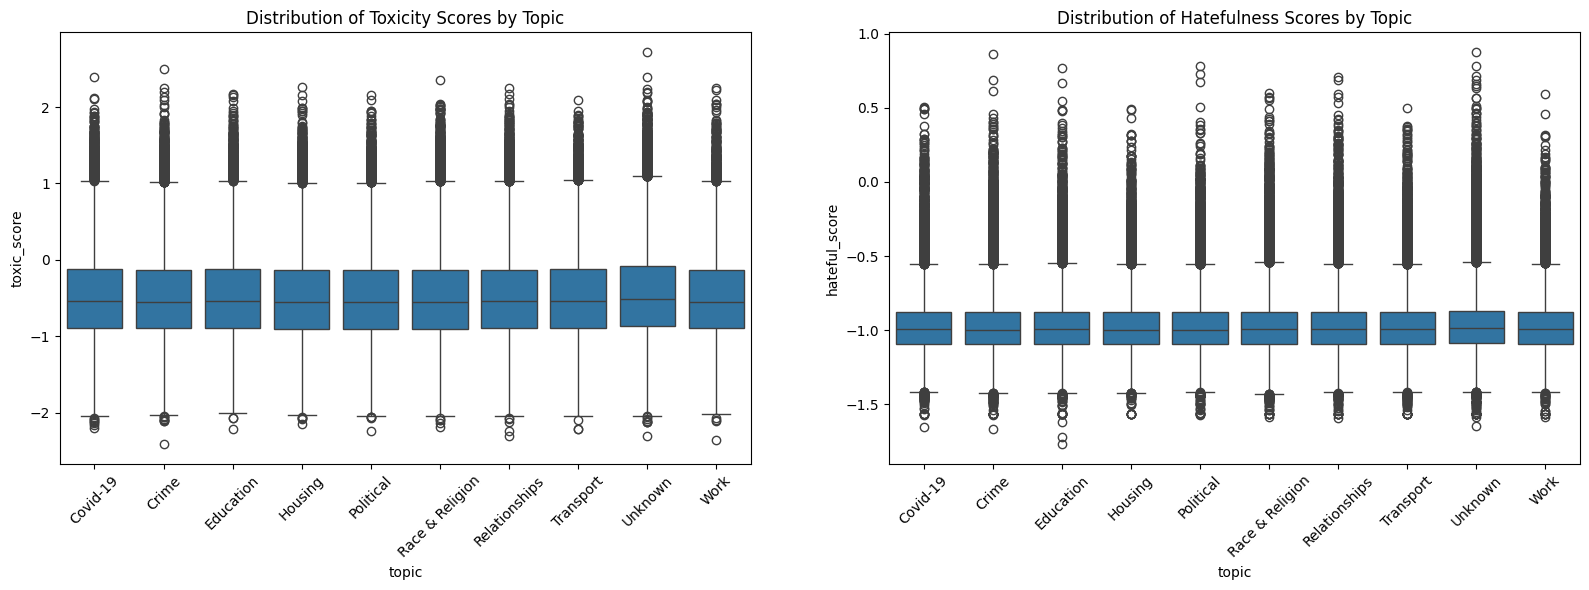

In [53]:
# Set the figure and axes for two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Boxplot for 'toxic_score'
sns.boxplot(data=results_df, x='topic', y='toxic_score', ax=axes[0])
axes[0].set_title('Distribution of Toxicity Scores by Topic')
axes[0].tick_params(axis='x', rotation=45)

# Second subplot: Boxplot for 'hateful_score'
sns.boxplot(data=results_df, x='topic', y='hateful_score', ax=axes[1])
axes[1].set_title('Distribution of Hatefulness Scores by Topic')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

### Histogram by topic

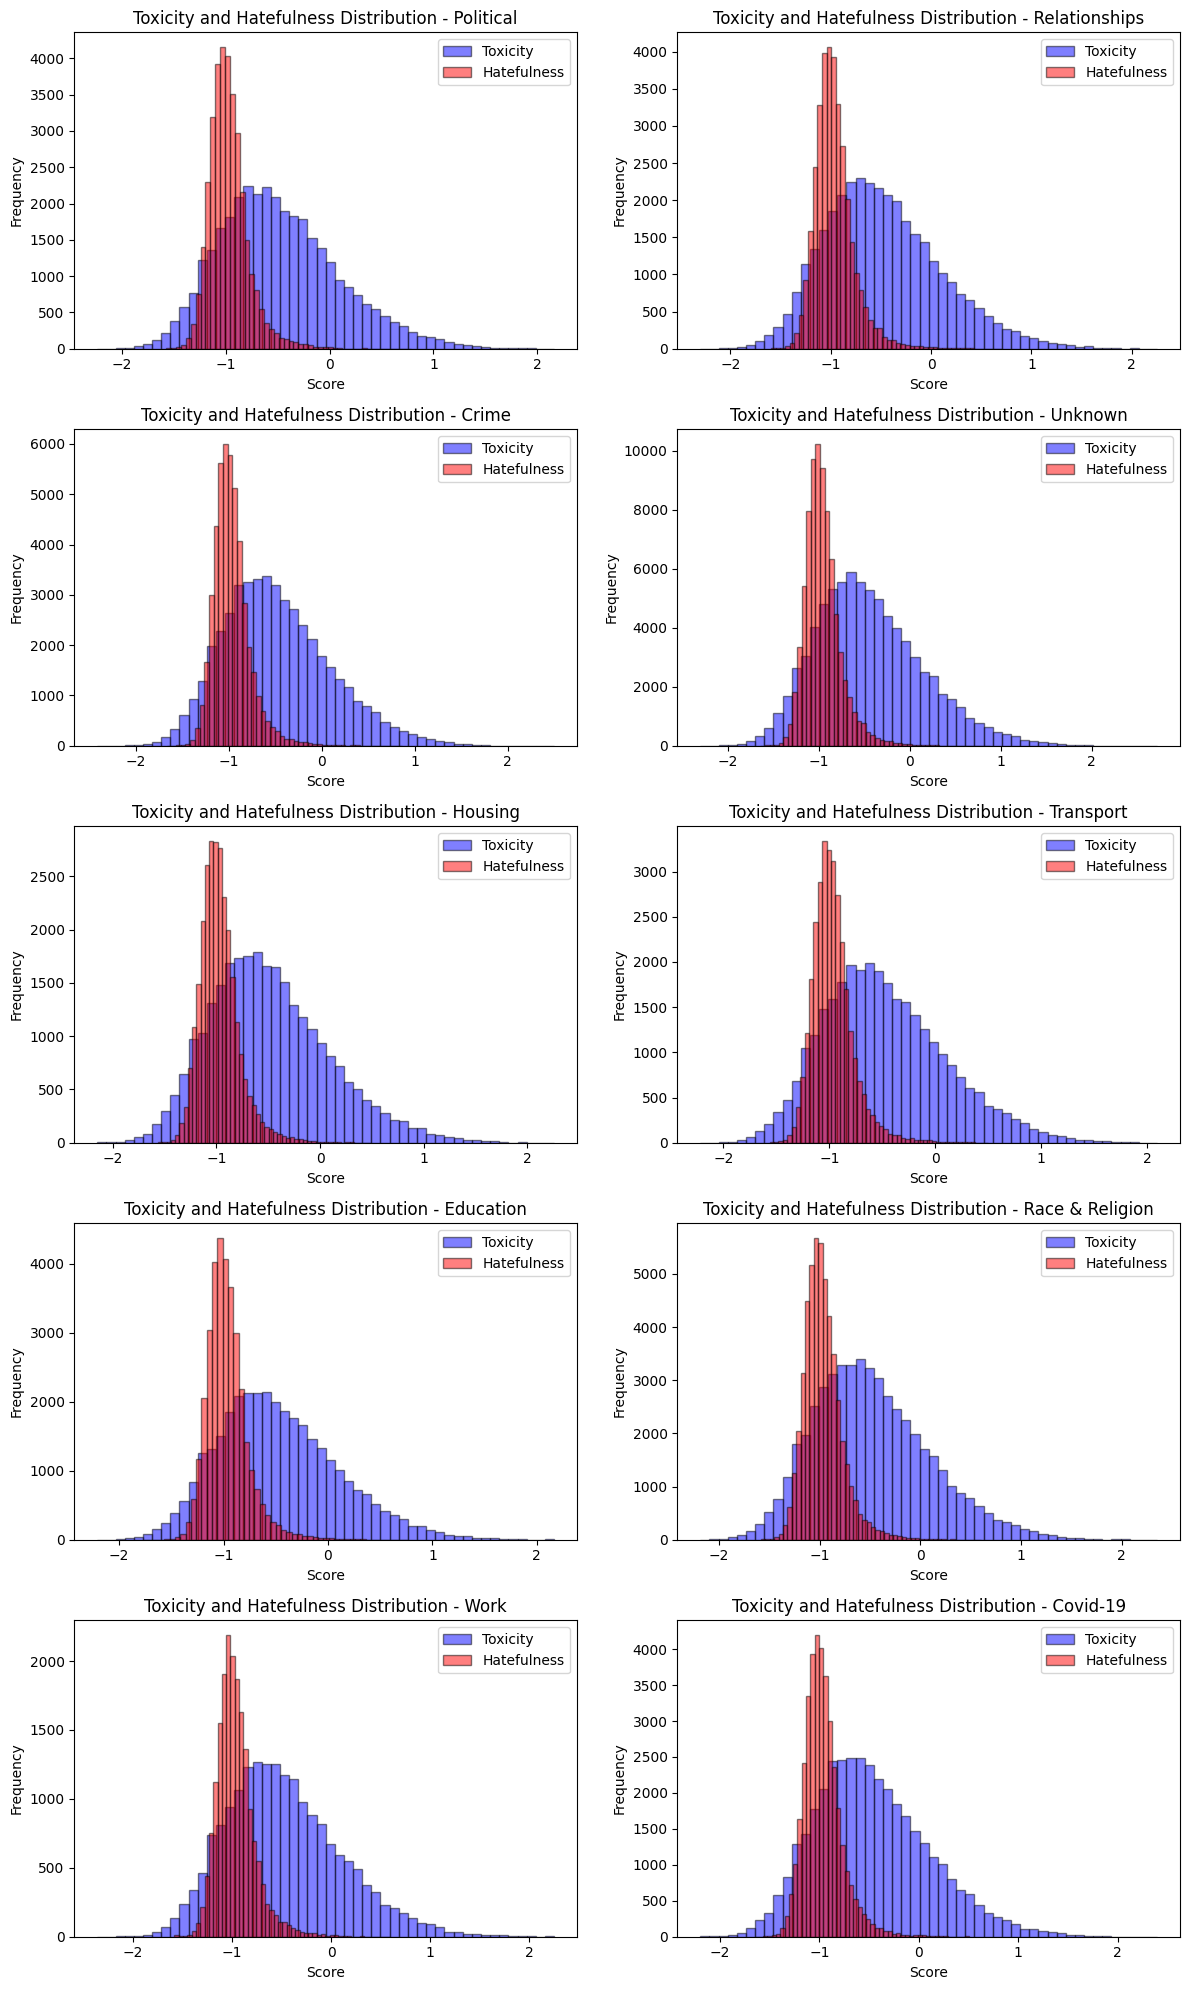

In [61]:
# Determine the number of rows and columns for the subplots
num_topics = len(unique_topics)
cols = 2  # Two plots per row (one for toxicity and one for hatefulness)
rows = (num_topics + 1) // cols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each topic and create a subplot
for i, topic in enumerate(unique_topics):
    topic_data = results_df[results_df['topic'] == topic]
    
    # Plot both histograms on the same axis (ax)
    axes[i].hist(topic_data['toxic_score'], bins=50, alpha=0.5, color='blue', label='Toxicity', edgecolor='black')
    axes[i].hist(topic_data['hateful_score'], bins=50, alpha=0.5, color='red', label='Hatefulness', edgecolor='black')
    
    # Set titles and labels
    axes[i].set_title(f"Toxicity and Hatefulness Distribution - {topic}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Frequency")
    axes[i].legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

### Analysis

- Statistics are similar across the different topics
    - No certain topic disproportiontely drives toxicity or hatefulness
- Mean toxic score is higher than mean hateful score across topics
    - Mean toxic score of topics are similar, with a small range of -0.48 to -0.44
    - Mean hateful score of topics are similar, with a small range of -0.98 to -0.96
- Spread of toxic score is larger than spread of hateful score across topics

- Histograms are slightly right skewed, and boxplots have more outliers on the upper end
    - Although mean scores are negative, there seems to be more cases of extreme toxic and hateful comments/isolated instances of heightened toxicity and hatefulness

## 1.2 Proportion of hateful and toxic comments

In [63]:
# Count total entries per category
topic_counts = results_df['topic'].value_counts()

# Count entries that are predicted hateful (binary output)
hatefulness_counts = results_df[results_df['hateful_prediction'] == 1]['topic'].value_counts()

# Combine the counts into a DataFrame
hate_counts_df = pd.DataFrame({
    'total': topic_counts,
    'hateful': hatefulness_counts
}).fillna(0)  # Fill NaN values with 0 for categories with no inner counts

# Calculate proportion
hate_counts_df['proportion_hateful'] = hate_counts_df['hateful'] / hate_counts_df['total']
hate_counts_df = hate_counts_df.reset_index().rename(columns = {'index': 'topic'})
hate_counts_df.sort_values(by = 'proportion_hateful', ascending = False)

,topic,total,hateful,proportion_hateful
8,Unknown,79771,1027,0.012874
1,Crime,46975,588,0.012517
2,Education,33762,410,0.012144
6,Relationships,34657,403,0.011628
7,Transport,31380,359,0.011440
5,Race & Religion,51109,576,0.011270
4,Political,34519,389,0.011269
9,Work,19009,214,0.011258
3,Housing,27467,295,0.010740
0,Covid-19,37649,377,0.010014


In [20]:
# Count total entries per category
topic_counts = results_df['topic'].value_counts()

# Count entries that fulfill the criteria (Score == 1)
toxic_counts = results_df[results_df['toxic_prediction'] == 1]['topic'].value_counts()

# Combine the counts into a DataFrame
toxic_counts_df = pd.DataFrame({
    'total': topic_counts,
    'toxic': toxic_counts
}).fillna(0)  # Fill NaN values with 0 for categories with no inner counts

# Calculate proportion
toxic_counts_df['proportion_toxic'] = toxic_counts_df['toxic'] / toxic_counts_df['total']
toxic_counts_df = toxic_counts_df.reset_index().rename(columns = {'index': 'topic'})
toxic_counts_df.sort_values(by = 'proportion_toxic', ascending = False)

,topic,total,toxic,proportion_toxic
8,Unknown,79771,14002,0.175527
0,Covid-19,37649,6118,0.162501
9,Work,19009,3056,0.160766
7,Transport,31380,5040,0.160612
2,Education,33762,5422,0.160595
1,Crime,46975,7512,0.159915
5,Race & Religion,51109,8150,0.159463
6,Relationships,34657,5497,0.158612
3,Housing,27467,4264,0.155241
4,Political,34519,5343,0.154784


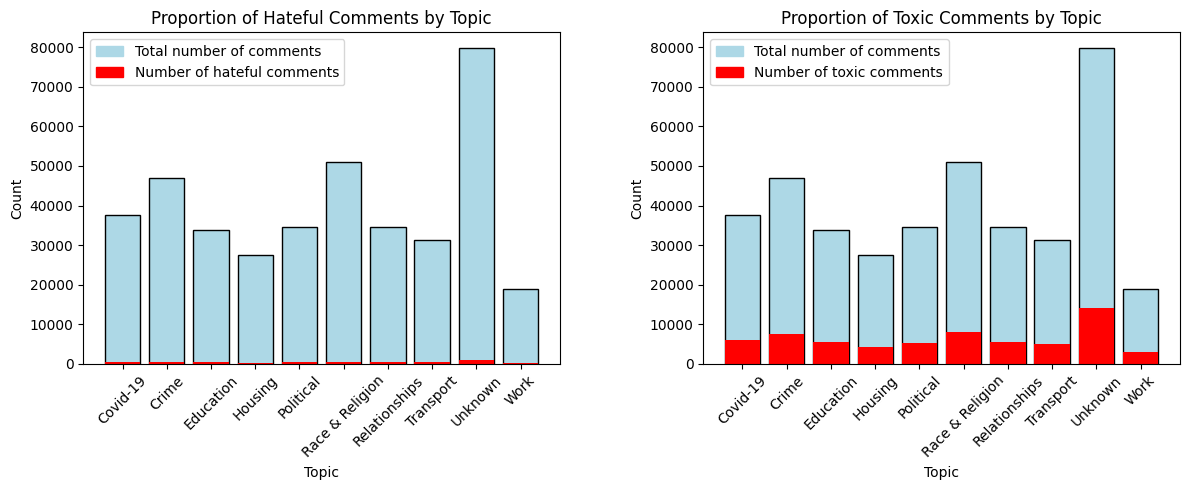

In [69]:
# Set figure size
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Create bars
bars = plt.bar(hate_counts_df['topic'], hate_counts_df['total'], color = 'lightblue', edgecolor = 'black', label = 'Total number of comments')

# Add inner bars for the proportion
for bar, hate_count in zip(bars, hate_counts_df['hateful']):
    height = bar.get_height()
    hate_bar_height = hate_count
    
    # Draw inner bar
    plt.bar(bar.get_x() + bar.get_width()/2, hate_bar_height, width=bar.get_width(), color='red', label = 'Number of hateful comments')

# Labels and title
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Proportion of Hateful Comments by Topic')
plt.xticks(rotation=45)
handles = [plt.Rectangle((0,0),1,1, color='lightblue'), plt.Rectangle((0,0),1,1, color='red')]
plt.legend(handles, ['Total number of comments', 'Number of hateful comments'])

plt.subplot(1, 2, 2)
# Create bars
bars = plt.bar(toxic_counts_df['topic'], toxic_counts_df['total'], color = 'lightblue', edgecolor = 'black', label = 'Total number of comments')

# Add inner bars for the proportion
for bar, toxic_count in zip(bars, toxic_counts_df['toxic']):
    height = bar.get_height()
    toxic_bar_height = toxic_count
    
    # Draw inner bar
    plt.bar(bar.get_x() + bar.get_width()/2, toxic_bar_height, width=bar.get_width(), color='red', label = 'Number of toxic comments')

# Labels and title
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Proportion of Toxic Comments by Topic')
plt.xticks(rotation=45)
handles = [plt.Rectangle((0,0),1,1, color='lightblue'), plt.Rectangle((0,0),1,1, color='red')]
plt.legend(handles, ['Total number of comments', 'Number of toxic comments'])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

### Analysis

- Across topics, more comments are flagged as toxic than hateful
    - Proportion of hateful comments range from 0.010 to 0.013
    - Proportion of toxic comments range from 0.15 to 0.18
- Proportion of comments that are hateful or toxic are similar between topics

## 1.3 Scatter plots to show the relationship between toxicity and hatefulness within topics.

To observe any clusters or correlations between toxicity and hatefulness across different topics. Topics with higher toxicity-hatefulness correlations are likely more controversial.

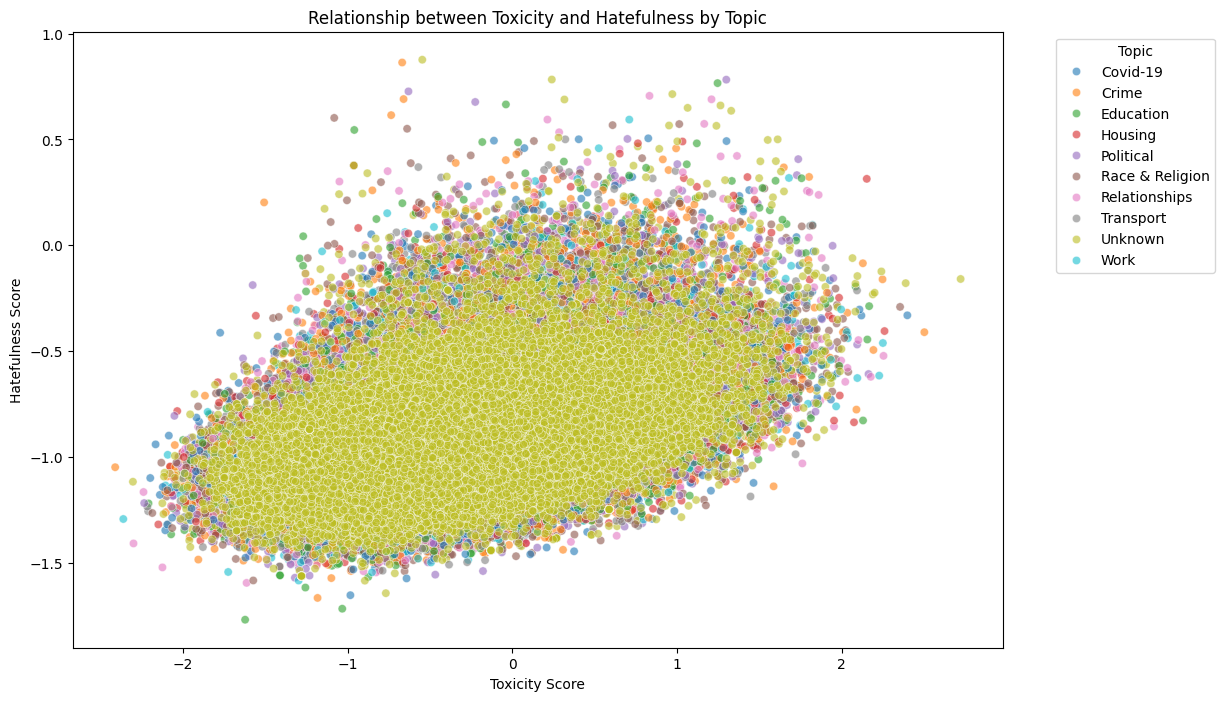

In [22]:
# Scatter plot for toxicity vs. hatefulness by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, x='toxic_score', y='hateful_score', hue='topic', alpha=0.6)
plt.title('Relationship between Toxicity and Hatefulness by Topic')
plt.xlabel('Toxicity Score')
plt.ylabel('Hatefulness Score')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Quite hard to tell, there are too many data points... so we decided to do a scatter plot matrix whereby each plot will represent 1 topic, displayed side by side such that we can see the relationships between hatefulness and toxicity within each topic clearly. We will also use a heatmap since there are many points, so the density can tell us more about the trend among the topics

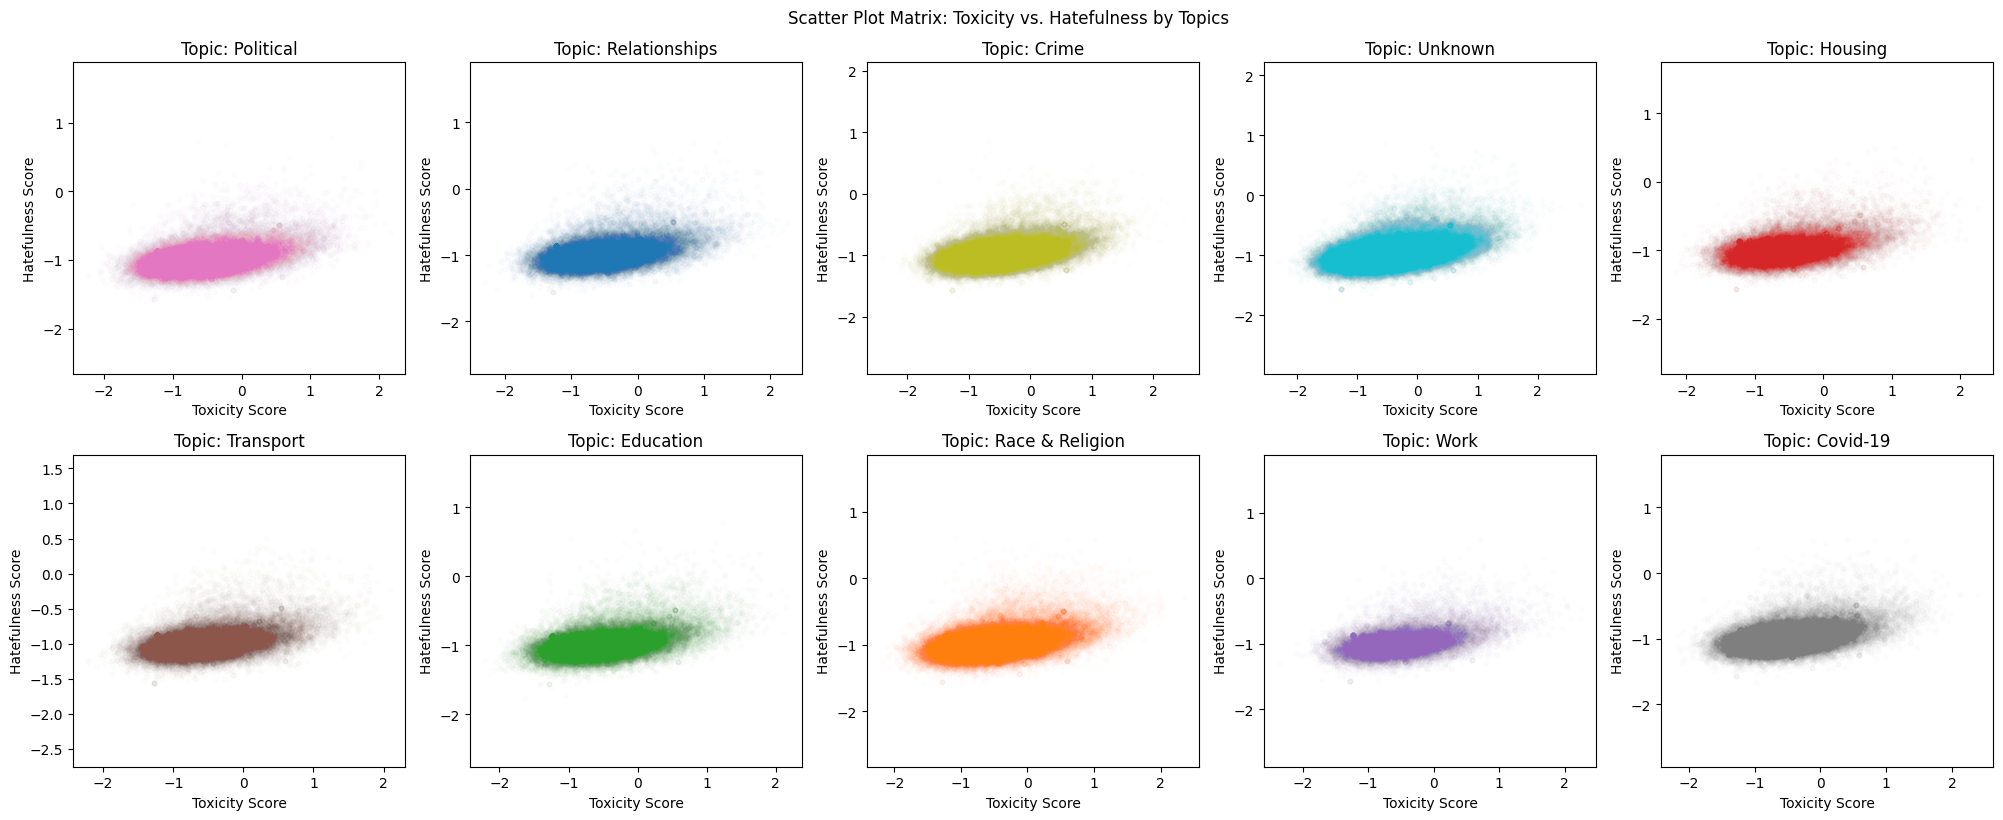

In [74]:
# Define consistent topics and their colors
consistent_topics = ['Race & Religion', 'Relationships', 'Education', 'Housing', 'Work', 'Transport']
topic_palette = {
    'Race & Religion': '#FF7F0E', 
    'Relationships': '#1F77B4', 
    'Education': '#2CA02C', 
    'Housing': '#D62728', 
    'Work': '#9467BD', 
    'Transport': '#8C564B',
    'Political': '#E377C2', 
    'Covid-19': '#7F7F7F', 
    'Crime': '#BCBD22',
    'Unknown': '#17BECF'
}

# Set up a grid for the 10 plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten to iterate over for each topic

# Plot each topic on a separate scatter plot
for idx, topic in enumerate(unique_topics):
    # Filter data for the current topic
    topic_data = results_df[results_df['topic'] == topic]
    
    # Create scatter plot with transparency to show density
    axes[idx].scatter(
        topic_data['toxic_score'], 
        topic_data['hateful_score'], 
        color=topic_palette[topic], 
        alpha=0.01,  # set the transparency of each point to be extremely low because of dense dataset
        s=10
    )
    
    # Set title and labels for each subplot
    axes[idx].set_title(f'Topic: {topic}')
    axes[idx].set_xlabel('Toxicity Score')
    axes[idx].set_ylabel('Hatefulness Score')

    axes[idx].set_aspect('equal', adjustable='datalim')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.suptitle("Scatter Plot Matrix: Toxicity vs. Hatefulness by Topics", y=1.02)
plt.show()

### Analysis
- Plots have the same shape across topics, with a rather strong but slight positive correlation.
- The size of the scatter seems to be proportionate to the number of data points (comments) in the particular topic.

# 2. Hypothesis Testing (ANOVA & Post-hoc)

## 2.1 ANOVA test

We will use the One-Way ANOVA to test the hypotheses:
- Hypothesis 1: Topics of big spike events more toxic than topics of consistent, everyday events
- Hypothesis 2: Topics of big spike events more hateful than topics of consistent, everyday events

Assumptions of the One-Way ANOVA:
Normality: The data within each group are approximately normally distributed. We see that distribution of hateful and toxic scores are approximately normal through the histogram plotted earlier.
Homogeneity of Variances: The variance of the two groups should be approximately equal. We see that standard deviation of hateful and toxic scores are approximately equal across topics.

This test determines if there are significant differences in toxicity and hatefulness scores across the topics. A low p-value (close to 0) in ANOVA results suggests that the topic categories likely influence score variance.

In [79]:
consistent_topics = ['Race & Religion', 'Relationships', 'Education', 'Housing', 'Work', 'Transport']
big_topics = ['Political', 'Covid-19', 'Crime']

# Hypothesis 1: "Big more toxic than consistent"
# Perform a one-way ANOVA test for the toxic scores
consistent_toxic = results_df[results_df['topic'].isin(consistent_topics)]['toxic_score']
big_toxic = results_df[results_df['topic'].isin(big_topics)]['toxic_score']
toxicity_anova = f_oneway(consistent_toxic, big_toxic)

# Hypothesis 2: "Big more hateful than consistent"
# Perform a one-way ANOVA test for the hateful scores
consistent_hateful = results_df[results_df['topic'].isin(consistent_topics)]['hateful_score']
big_hateful = results_df[results_df['topic'].isin(big_topics)]['hateful_score']
hateful_anova = f_oneway(consistent_hateful, big_hateful)

# Results
print(f"ANOVA result for Toxicity Scores: F-statistic = {toxicity_anova.statistic:.4f}, p-value = {toxicity_anova.pvalue:.4f}")
print(f"ANOVA result for Hatefulness Scores: F-statistic = {hateful_anova.statistic:.4f}, p-value = {hateful_anova.pvalue:.4f}")

ANOVA result for Toxicity Scores: F-statistic = 0.1673, p-value = 0.6825
ANOVA result for Hatefulness Scores: F-statistic = 1.4017, p-value = 0.2364


### Analysis

- p-value for both ANOVA tests are large, with p-value for Toxicity Scores at 0.68 and p-value for Hatefulness Scores at 0.24
- We do not reject the hypothesis, and do not have strong evidence that topics of big spike events are any more toxic or hateful than topics of consistent events